In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from release.code.setup_problem import load_problem
from release.code.ridge_regression import RidgeRegression, do_grid_search_ridge, plot_prediction_functions, plot_confusion_matrix, compare_parameter_vectors

PICKLE_PATH = 'release/code/lasso_data.pickle'

In [2]:
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(PICKLE_PATH)
X_train = featurize(x_train)
X_val = featurize(x_val)

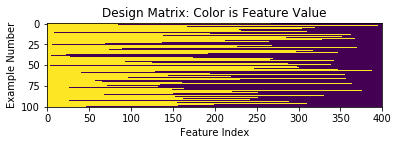

In [3]:
#Visualize training data
fig, ax = plt.subplots()
ax.set_title("Design Matrix: Color is Feature Value")
ax.set_xlabel("Feature Index")
ax.set_ylabel("Example Number")
ax.imshow(X_train)

# 2.1 Grid Search for the best parameter

In [4]:
grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)

In [5]:
results

,param_l2reg,mean_test_score,mean_train_score
0,0.000001,0.172579,0.006752
1,0.000010,0.172464,0.006752
2,0.000100,0.171345,0.006774
3,0.001000,0.162705,0.008285
4,0.010000,0.141887,0.032767
5,0.100000,0.144566,0.094953
6,1.000000,0.171068,0.197694
7,1.300000,0.179521,0.216591
8,1.600000,0.187993,0.233450
9,1.900000,0.196361,0.248803


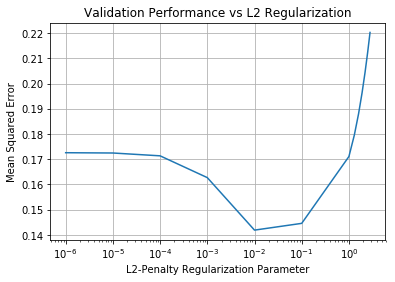

In [6]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
ax.semilogx(results["param_l2reg"], results["mean_test_score"])

# 2.2 Visualizing the Prediction Functions

In [7]:
# Let's plot prediction functions and compare coefficients for several fits
# and the target function.
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))

pred_fns.append({"name": "Target Parameter Values (i.e. Bayes Optimal)", "coefs": coefs_true, "preds": target_fn(x)})

l2regs = [0, grid.best_params_['l2reg']]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })

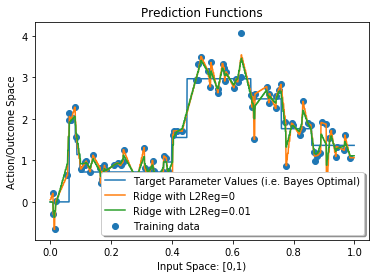

In [8]:
plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")

## Visualizing the coefficients

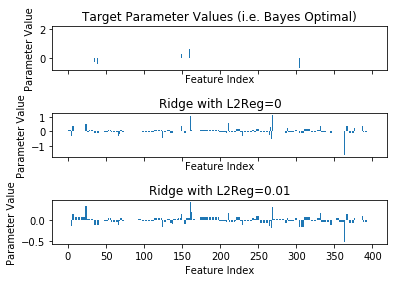

In [9]:
compare_parameter_vectors(pred_fns)

# 2.3 Predicting the sparsity pattern of parameters

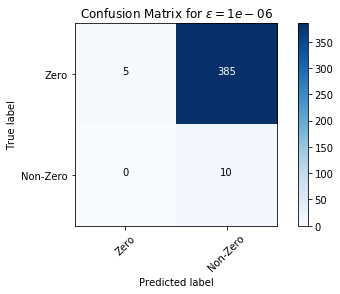

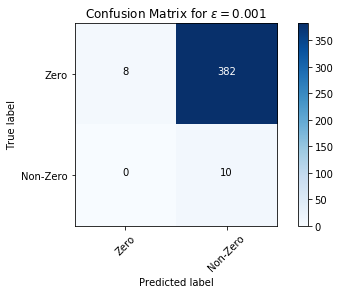

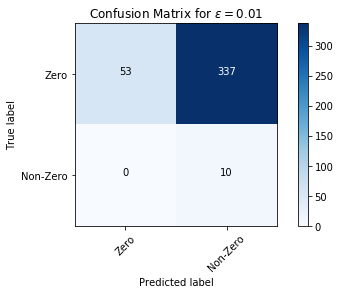

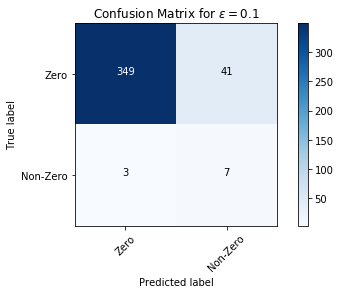

In [10]:
bin_coefs_true = (coefs_true != 0.0).astype(np.int_)
eps_list = [1e-6, 1e-3, 1e-2, 1e-1]
for eps in eps_list:
    bin_coefs_estimated = (np.abs(pred_fns[-1]["coefs"]) > eps).astype(np.int_)
    cnf_matrix = confusion_matrix(bin_coefs_true, bin_coefs_estimated)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(eps), classes=["Zero", "Non-Zero"])